# Extended XGBoost Classifier - Soccer O/U 2.5 Goals Prediction

**Objective**: Build and evaluate an extended XGBoost classifier using extended soccer match features to predict Over/Under 2.5 goals.

**Tasks**:
- Load extended preprocessed data
- Build extended XGBoost classifier  
- Train and validate model
- Hyperparameter tuning
- Feature importance analysis
- Performance comparison (tuned vs untuned)
- XGBoost with extended features

## 1. Setup and Data Loading

### 1.1 Import Libraries

Importing all necessary libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings('ignore', category=Warning) # Suppress convergence warnings from Gaussian Process
import joblib
import os

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Machine Learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve, ShuffleSplit
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, log_loss
)

# Bayesian Optimization
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.2 Evaluation function

We will setup a function, that we can use for the models we create further on.

In [2]:
# Function to calculate comprehensive metrics
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """Calculate comprehensive classification metrics"""
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'log_loss': log_loss(y_true, y_pred_proba),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
    
    print(f"\n📈 {model_name} Performance Metrics:")
    print("=" * 50)
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"Log Loss:   {metrics['log_loss']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

### 1.3 Load Extended Preprocessed Data

Sanity checks for the datasets and checking the distributions and shapes of the data splits.

In [3]:
# Load the extended preprocessed data

with open('./outputs/processed/extended_preprocessed.pkl', 'rb') as f:
    extended_data = pickle.load(f)

# Extract all datasets including validation
X_train_extended = extended_data['X_train']
X_val_extended = extended_data['X_val']
X_test_extended = extended_data['X_test'] 
y_train = extended_data['y_train']
y_val = extended_data['y_val']
y_test = extended_data['y_test']

print(f"\n📊 Dataset Shapes:")
print(f"Training set: {X_train_extended.shape}")
print(f"Validation set: {X_val_extended.shape}")
print(f"Test set: {X_test_extended.shape}")
print(f"Features: {X_train_extended.shape[1]}")

print(f"\n🎯 Target Distribution:")
print(f"Training - Over 2.5: {y_train.mean():.2%}")
print(f"Validation - Over 2.5: {y_val.mean():.2%}")
print(f"Test - Over 2.5: {y_test.mean():.2%}")


# Display data split summary
total_samples = len(y_train) + len(y_val) + len(y_test)
print(f"\n📈 Data Split Summary:")
print(f"Total samples: {total_samples:,}")
print(f"Training: {len(y_train):,} ({len(y_train)/total_samples:.1%})")
print(f"Validation: {len(y_val):,} ({len(y_val)/total_samples:.1%})")
print(f"Test: {len(y_test):,} ({len(y_test)/total_samples:.1%})")


📊 Dataset Shapes:
Training set: (28217, 703)
Validation set: (7247, 703)
Test set: (7129, 703)
Features: 703

🎯 Target Distribution:
Training - Over 2.5: 49.00%
Validation - Over 2.5: 53.14%
Test - Over 2.5: 50.69%

📈 Data Split Summary:
Total samples: 42,593
Training: 28,217 (66.2%)
Validation: 7,247 (17.0%)
Test: 7,129 (16.7%)


The dataset needed some cleaning in column names for XGBOOST. So we replace characters ([ ] < >) in column names to satisfy XGBoost’s parser.


In [4]:
# Clean feature names - remove characters that XGBoost doesn't allow: [, ], <, > (which are in betting odds features)
def clean_feature_names(df):
    """Remove special characters from feature names that XGBoost doesn't allow"""
    df.columns = df.columns.str.replace('[', '(', regex=False)
    df.columns = df.columns.str.replace(']', ')', regex=False)
    df.columns = df.columns.str.replace('<', 'less_than_', regex=False)
    df.columns = df.columns.str.replace('>', 'greater_than_', regex=False)
    return df

# Clean all datasets
X_train_extended = clean_feature_names(X_train_extended)
X_val_extended = clean_feature_names(X_val_extended)
X_test_extended = clean_feature_names(X_test_extended)

print("\n✅ Feature names cleaned for XGBoost compatibility")


✅ Feature names cleaned for XGBoost compatibility


## 2 Modeling

### 2.1 Extended model

Baseline fit (no tuning). In tje next cells we'll add validation set, early stopping, and hyper-parameter search.


In [5]:
# Create extended XGBoost classifier with default parameters

# Initialize XGBoost with basic parameters
xgb_extended = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0  # Suppress training output
)


# Train the extended XGBoost model
xgb_extended.fit(X_train_extended, y_train)


# Make predictions on validation set
y_val_pred_extended = xgb_extended.predict(X_val_extended)
y_val_pred_proba_extended = xgb_extended.predict_proba(X_val_extended)[:, 1]


# Evaluate extended model
extended_metrics = evaluate_model(
    y_val, y_val_pred_extended, y_val_pred_proba_extended, 
    "Extended XGBoost (Validation)"
)



📈 Extended XGBoost (Validation) Performance Metrics:
Accuracy:  0.5513
Precision: 0.5810
Recall:    0.5578
F1-Score:  0.5692
Log Loss:   0.7363
ROC-AUC:   0.5735


## 2.2 Hyperparameter Optimization with Optuna

#### 2.2.1 Definition of optimized parameters and training training-validation function

Now we define the hyperparamter search space and train - to restrict depth and increase regularization to reduce variance. We’ll use log loss for early stopping and tuning since we need good probabilities for betting metrics.

In [6]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization
    Returns: log loss score to maximize
    """
    
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': 0,
        
        # Tree structure parameters - adjusted for high dimensions (344+ features)
        'max_depth': trial.suggest_int('max_depth', 4, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 20),
        
        # Sampling parameters - crucial for high dimensions
        'subsample': trial.suggest_float('subsample', 0.7, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 0.9),
        
        # Boosting parameters
        'n_estimators': trial.suggest_int('n_estimators', 100, 4000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.8, log=True),
        
        # Regularization parameters - stronger for high dimensions
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 50.0),
        
        # Advanced parameters
        'gamma': trial.suggest_float('gamma', 0.1, 10.0),
    }
    
    # Create and train model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_extended, y_train)
    
    # Predict on validation set
    y_pred_proba = model.predict_proba(X_val_extended)[:, 1]  # Extract positive class probabilities
    
    # Return negative log loss (higher is better since we minimize log loss)
    logloss = log_loss(y_val, y_pred_proba)
    
    return -logloss



#### 2.2.2 Running optuna optimization with 250 trials

Tuning on the single validation season.


In [7]:
### 3.3 Run Hyperparameter Optimization

# Create study with TPE sampler for efficient search
study = optuna.create_study(
    direction='maximize',  # We want to minimize log loss (maximize negative log loss)
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='xgboost_soccer_prediction'
)

# Record start time
start_time = time.time()

# Run optimization with more trials for high-dimensional space
N_TRIALS = 250  # More trials needed for complex parameter space with 344+ features
print(f"🚀 Running {N_TRIALS} trials for high-dimensional optimization...")

study.optimize(objective, n_trials=N_TRIALS)

# Calculate optimization time
optimization_time = time.time() - start_time

print(f"✅ Optimization completed in {optimization_time:.1f} seconds")
print(f"📊 Best Log Loss: {-study.best_value:.6f}")
print(f"🏆 Best trial: #{study.best_trial.number}")


[I 2025-11-16 17:14:45,491] A new study created in memory with name: xgboost_soccer_prediction


🚀 Running 250 trials for high-dimensional optimization...


[I 2025-11-16 17:14:54,741] Trial 0 finished with value: -0.6712784878298762 and parameters: {'max_depth': 14, 'min_child_weight': 20, 'subsample': 0.8829984854528512, 'colsample_bytree': 0.5190609389379257, 'colsample_bylevel': 0.22481491235394924, 'n_estimators': 700, 'learning_rate': 0.006714184244399761, 'reg_alpha': 17.33690530092121, 'reg_lambda': 30.45463557541723, 'gamma': 7.109918520180851}. Best is trial 0 with value: -0.6712784878298762.
[I 2025-11-16 17:15:03,879] Trial 1 finished with value: -0.6715679859765926 and parameters: {'max_depth': 4, 'min_child_weight': 20, 'subsample': 0.9081106602001054, 'colsample_bytree': 0.24863737747479334, 'colsample_bylevel': 0.24545997376568052, 'n_estimators': 800, 'learning_rate': 0.023418356423825146, 'reg_alpha': 10.542652989481532, 'reg_lambda': 22.165305913463673, 'gamma': 2.983168487960615}. Best is trial 0 with value: -0.6712784878298762.
[I 2025-11-16 17:17:46,778] Trial 2 finished with value: -0.687058007152639 and parameters: 

✅ Optimization completed in 2746.7 seconds
📊 Best Log Loss: 0.670307
🏆 Best trial: #224


#### 2.2.3 Best parameters according to optuna

In [8]:
print("📋 Best hyperparameters:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

📋 Best hyperparameters:
   max_depth: 28
   min_child_weight: 15
   subsample: 0.826090493006794
   colsample_bytree: 0.7347270955265653
   colsample_bylevel: 0.5449423730250477
   n_estimators: 1700
   learning_rate: 0.019759500079530323
   reg_alpha: 8.39581290349202
   reg_lambda: 24.834882004404133
   gamma: 9.230712310300436


Now let's use manual Bayesian for the optimization for enough runs and see how it measures up to optuna in this case.

## 2.3 Hyperparameter Optimization with manual Bayesian Optimization

In [9]:


# --------------------------------------------
#  Define objective function (same as Optuna)
# --------------------------------------------
def evaluate_xgb_manual(params):
    """Train XGBoost and evaluate Log Loss on validation - matches Optuna objective."""
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
        # Parameters in same order as bounds array
        max_depth=int(params[0]),
        min_child_weight=int(params[1]),
        subsample=params[2],
        colsample_bytree=params[3],
        colsample_bylevel=params[4],
        n_estimators=int(params[5]),
        learning_rate=params[6],
        reg_alpha=params[7],
        reg_lambda=params[8],
        gamma=params[9]
    )

    model.fit(X_train_extended, y_train)
    y_pred_val = model.predict_proba(X_val_extended)[:, 1]  # Extract positive class probabilities
    logloss = log_loss(y_val, y_pred_val)
    # We minimize log loss directly
    return logloss

# --------------------------------------------
#  Define search space bounds (matching Optuna exactly)
# --------------------------------------------
param_bounds = np.array([
    [4, 30],         # max_depth: 4-30
    [3, 20],         # min_child_weight: 3-20
    [0.7, 0.95],     # subsample: 0.7-0.95
    [0.1, 0.8],      # colsample_bytree: 0.1-0.8
    [0.1, 0.9],      # colsample_bylevel: 0.1-0.9
    [100, 4000],     # n_estimators: 100-4000
    [0.005, 0.8],    # learning_rate: 0.005-0.8
    [0.1, 20.0],     # reg_alpha: 0.1-20.0
    [1.0, 50.0],     # reg_lambda: 1.0-50.0
    [0.1, 10.0],     # gamma: 0.1-10.0
])

n_params = param_bounds.shape[0]

# --------------------------------------------
#  Initialize samples (random warm-up)
# --------------------------------------------
np.random.seed(RANDOM_STATE)
N_INIT = 15  # More initial samples for 10-dimensional space


X_samples = np.random.uniform(param_bounds[:, 0], param_bounds[:, 1], size=(N_INIT, n_params))
Y_samples = np.array([evaluate_xgb_manual(x) for x in X_samples])

# --------------------------------------------
#  Fit Gaussian Process surrogate
# --------------------------------------------
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=RANDOM_STATE)

# Scaler helps GP fit parameters of different magnitudes 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_samples)
gp.fit(X_scaled, Y_samples)

# --------------------------------------------
#  Acquisition function (Upper Confidence Bound)
# --------------------------------------------
def acquisition_ucb(X, model, kappa=2.0):
    """Upper Confidence Bound acquisition function"""
    mu, sigma = model.predict(X, return_std=True)
    return mu - kappa * sigma  # minimizing log loss

def propose_next(model, bounds, n_candidates=3000):
    """Propose next point to evaluate"""
    candidates = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_candidates, bounds.shape[0]))
    candidates_scaled = scaler.transform(candidates)
    acq_vals = acquisition_ucb(candidates_scaled, model)
    best_idx = np.argmin(acq_vals)
    return candidates[best_idx].reshape(1, -1), np.min(acq_vals)

# --------------------------------------------
#  Iterative Bayesian Optimization loop
# --------------------------------------------
N_ITER = 250  # More iterations to match Optuna's exploration capacity
history_best = [np.min(Y_samples)]

print(f"\n🚀 Starting Bayesian Optimization with {N_ITER} iterations...")
start_time = time.time()

for i in range(N_ITER):
    # Propose next point
    x_next, acq_val = propose_next(gp, param_bounds)
    y_next = evaluate_xgb_manual(x_next[0])
    
    # Update datasets
    X_samples = np.vstack([X_samples, x_next])
    Y_samples = np.hstack([Y_samples, y_next])

    # Refit Gaussian Process
    X_scaled = scaler.fit_transform(X_samples)
    gp.fit(X_scaled, Y_samples)

    # Track progress
    history_best.append(np.min(Y_samples))
    current_best_logloss = np.min(Y_samples)
    
    if (i + 1) % 10 == 0 or i < 5:  # Print progress every 10 iterations
        print(f"Iteration {i+1:02d}: Best Log Loss = {current_best_logloss:.5f}")

optimization_time = time.time() - start_time

# --------------------------------------------
#  Final results and comparison
# --------------------------------------------
best_idx = np.argmin(Y_samples)
best_params_array = X_samples[best_idx]
best_logloss = Y_samples[best_idx]



# Create parameter dictionary in same format as Optuna
param_names = ["max_depth", "min_child_weight", "subsample", "colsample_bytree",
               "colsample_bylevel", "n_estimators", "learning_rate", "reg_alpha",
               "reg_lambda", "gamma"]

# Convert to dictionary format matching Optuna output
manual_bo_params = {}
for i, name in enumerate(param_names):
    if name in ["max_depth", "min_child_weight", "n_estimators"]:
        manual_bo_params[name] = int(best_params_array[i])
    else:
        manual_bo_params[name] = float(best_params_array[i])

print(f"\n📋 Best hyperparameters found:")
for name, val in manual_bo_params.items():
    if isinstance(val, int):
        print(f"  {name:18}: {val}")
    else:
        print(f"  {name:18}: {val:.4f}")



print(f"\n🏆 Manual Bayesian Optimization Results:")
print(f"⏱️  Optimization time: {optimization_time:.1f} seconds")
print(f"🎯 Best validation Log Loss: {best_logloss:.6f}")
print(f"📊 Total evaluations: {len(Y_samples)}")



🚀 Starting Bayesian Optimization with 250 iterations...
Iteration 01: Best Log Loss = 0.67109
Iteration 02: Best Log Loss = 0.67109
Iteration 03: Best Log Loss = 0.67109
Iteration 04: Best Log Loss = 0.67084
Iteration 05: Best Log Loss = 0.67067
Iteration 10: Best Log Loss = 0.67066
Iteration 20: Best Log Loss = 0.67059
Iteration 30: Best Log Loss = 0.67059
Iteration 40: Best Log Loss = 0.67059
Iteration 50: Best Log Loss = 0.67059
Iteration 60: Best Log Loss = 0.67059
Iteration 70: Best Log Loss = 0.67058
Iteration 80: Best Log Loss = 0.67058
Iteration 90: Best Log Loss = 0.67058
Iteration 100: Best Log Loss = 0.67058
Iteration 110: Best Log Loss = 0.67058
Iteration 120: Best Log Loss = 0.67058
Iteration 130: Best Log Loss = 0.67053
Iteration 140: Best Log Loss = 0.67053
Iteration 150: Best Log Loss = 0.67053
Iteration 160: Best Log Loss = 0.67053
Iteration 170: Best Log Loss = 0.67053
Iteration 180: Best Log Loss = 0.67053
Iteration 190: Best Log Loss = 0.67041
Iteration 200: Best L

The final log loss is very comparable, we will take a closer look.


## 2.4 Comparison of optuna vs manual

#### 2.4.1 Best parameters according to both approaches

In [10]:

# Extract best parameters from Optuna study
optuna_params = study.best_params
optuna_logloss = -study.best_value

print(f"\n📊 Comparison of Best Hyperparameters:")
print(f"{'Parameter':<18} {'Optuna':<15}        {'Manual BO':<15}")
print("-" * 50)

for param in param_names:
    optuna_val = optuna_params.get(param, 'N/A')
    manual_val = manual_bo_params.get(param, 'N/A')
    
    if isinstance(manual_val, int):
        print(f"{param:<18} {optuna_val:<15}              {manual_val:<15}")
    else:
        
        print(f"{param:<18} {optuna_val:<15}         {manual_val:.4f}")

print(f"\n🎯 Best Log Loss Comparison:")
print(f"Optuna Log Loss:    {optuna_logloss:.6f}")
print(f"Manual BO Log Loss: {best_logloss:.6f}")
print(f"Difference:    {abs(optuna_logloss - best_logloss):.6f}")




📊 Comparison of Best Hyperparameters:
Parameter          Optuna                 Manual BO      
--------------------------------------------------
max_depth          28                           25             
min_child_weight   15                           19             
subsample          0.826090493006794         0.7153
colsample_bytree   0.7347270955265653         0.5788
colsample_bylevel  0.5449423730250477         0.8909
n_estimators       1700                         3713           
learning_rate      0.019759500079530323         0.1182
reg_alpha          8.39581290349202         19.3028
reg_lambda         24.834882004404133         31.5277
gamma              9.230712310300436         9.8265

🎯 Best Log Loss Comparison:
Optuna Log Loss:    0.670307
Manual BO Log Loss: 0.670397
Difference:    0.000091


We can clearly see, that some hyperparameters, such as gamma were picked out very similarly, many other differ. For example Optuna prefers more trees with slower learning in contrast to manual BO. Both converged to very similar validation performance though, even with different paths.

## 2.5 Training Models with optimized parameters 

In [11]:


# Model trained with Optuna best parameters
xgb_optuna = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **optuna_params
)

xgb_optuna.fit(X_train_extended, y_train)
y_pred_val_optuna = xgb_optuna.predict_proba(X_val_extended)[:, 1]
log_loss_optuna = log_loss(y_val, y_pred_val_optuna)
print(f"✅ Optuna model Log Loss: {log_loss_optuna:.6f}")

# Model trained with Manual Bayesian Optimization best parameters  
xgb_manual = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **manual_bo_params
)

xgb_manual.fit(X_train_extended, y_train)
y_pred_val_manual = xgb_manual.predict_proba(X_val_extended)[:, 1]  # Extract positive class probabilities
log_loss_manual = log_loss(y_val, y_pred_val_manual)
print(f"✅ Manual BO model Log Loss: {log_loss_manual:.6f}")

print(f"\n📊 Final Validation Results (Optimized for Log Loss):")
print(f"Extended XGBoost:     Log Loss = {extended_metrics['log_loss']:.6f} | Accuracy = {extended_metrics['accuracy']:.6f}")
print(f"Optuna Optimized:     Log Loss = {log_loss_optuna:.6f} | Accuracy = {accuracy_score(y_val, (y_pred_val_optuna >= 0.5).astype(int)):.6f}")
print(f"Manual BO Optimized:  Log Loss = {log_loss_manual:.6f} | Accuracy = {accuracy_score(y_val, (y_pred_val_manual >= 0.5).astype(int)):.6f}")
print(f"\n🏆 Best Log Loss: {min(extended_metrics['log_loss'], log_loss_optuna, log_loss_manual):.6f}")    



✅ Optuna model Log Loss: 0.670307
✅ Manual BO model Log Loss: 0.670397

📊 Final Validation Results (Optimized for Log Loss):
Extended XGBoost:     Log Loss = 0.736306 | Accuracy = 0.551263
Optuna Optimized:     Log Loss = 0.670307 | Accuracy = 0.582862
Manual BO Optimized:  Log Loss = 0.670397 | Accuracy = 0.582862

🏆 Best Log Loss: 0.670307


## 2.6 Final Model Training on Train + Validation Data

**Important Methodological Note:**

While hyperparameters were optimized using:
- **Training data**: 2019-2023 seasons (for model fitting during optimization)
- **Validation data**: 2023/2024 season (for hyperparameter selection)

The **final models** for test evaluation are retrained on the **combined train+validation dataset** (2019-2024) to:
1. ✅ Use all available historical data before predicting 2024/2025
2. ✅ Provide maximum seasonal context (5 full seasons vs 4)
3. ✅ Maintain proper evaluation: test set (2024/2025) was never used in tuning or training

This approach is standard practice in time-series ML: tune on historical splits, then retrain on all available data before final deployment/evaluation.

#### 2.6.1 Combine Train and Validation Data

In [12]:
# Combine training and validation data for final model training
# This gives us 2019-2024 seasons for training before predicting 2024/2025

X_train_full = pd.concat([X_train_extended, X_val_extended], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Reset indices to ensure clean indexing
X_train_full.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)

print(f"📊 Combined Training Data (Train + Validation):")
print(f"Features: {X_train_full.shape}")
print(f"Samples: {len(y_train_full):,}")
print(f"  - Original Train: {len(y_train):,} (2019-2023)")
print(f"  - Original Val:   {len(y_val):,} (2023/2024)")
print(f"  - Combined:       {len(y_train_full):,} (2019-2024)")
print(f"\nTarget Distribution (Combined): {y_train_full.mean():.2%} Over 2.5 goals")

📊 Combined Training Data (Train + Validation):
Features: (35464, 703)
Samples: 35,464
  - Original Train: 28,217 (2019-2023)
  - Original Val:   7,247 (2023/2024)
  - Combined:       35,464 (2019-2024)

Target Distribution (Combined): 49.85% Over 2.5 goals


#### 2.6.2 Retrain Final Models on Combined Data

Retraining on the combined 2019-2024 data before a test set evaluation, which remains unseen to the model.

In [13]:
# ===== 1. Baseline Extended Model (retrained on full data) =====
print("🔄 Training Baseline Extended model on Train+Val data...")

xgb_extended_final = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)

xgb_extended_final.fit(X_train_full, y_train_full)
print("✅ Baseline Extended model trained on combined data")


# ===== 2. Optuna-Optimized Model (retrained on full data) =====
print("\n🔄 Training Optuna-optimized model on Train+Val data...")

xgb_optuna_final = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **optuna_params  # Use best hyperparameters from Optuna
)

xgb_optuna_final.fit(X_train_full, y_train_full)
print("✅ Optuna-optimized model trained on combined data")


# ===== 3. Manual BO-Optimized Model (retrained on full data) =====
print("\n🔄 Training Manual BO-optimized model on Train+Val data...")

xgb_manual_final = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    **manual_bo_params  # Use best hyperparameters from Manual BO
)

xgb_manual_final.fit(X_train_full, y_train_full)
print("✅ Manual BO-optimized model trained on combined data")

print("\n" + "="*60)
print("🎯 All final models ready for test set evaluation")
print("   Training data: 2019-2024 (Train + Validation)")
print("   Test data:     2024/2025 (Unseen)")
print("="*60)

🔄 Training Baseline Extended model on Train+Val data...
✅ Baseline Extended model trained on combined data

🔄 Training Optuna-optimized model on Train+Val data...
✅ Optuna-optimized model trained on combined data

🔄 Training Manual BO-optimized model on Train+Val data...
✅ Manual BO-optimized model trained on combined data

🎯 All final models ready for test set evaluation
   Training data: 2019-2024 (Train + Validation)
   Test data:     2024/2025 (Unseen)


# 3 Analysis

## 3.1 Feature Importance in All Three Final Models (Trained on Train+Val)

<Figure size 1200x800 with 0 Axes>

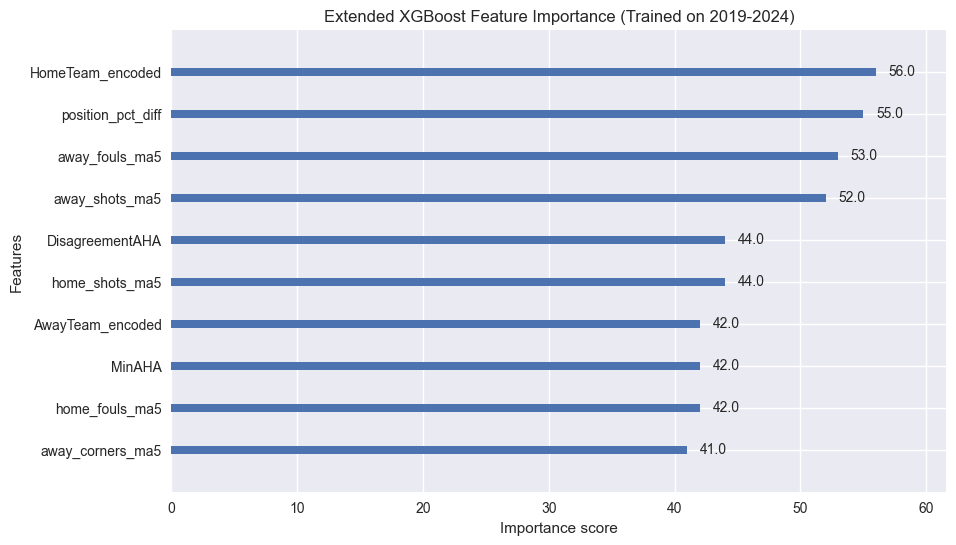

<Figure size 1200x800 with 0 Axes>

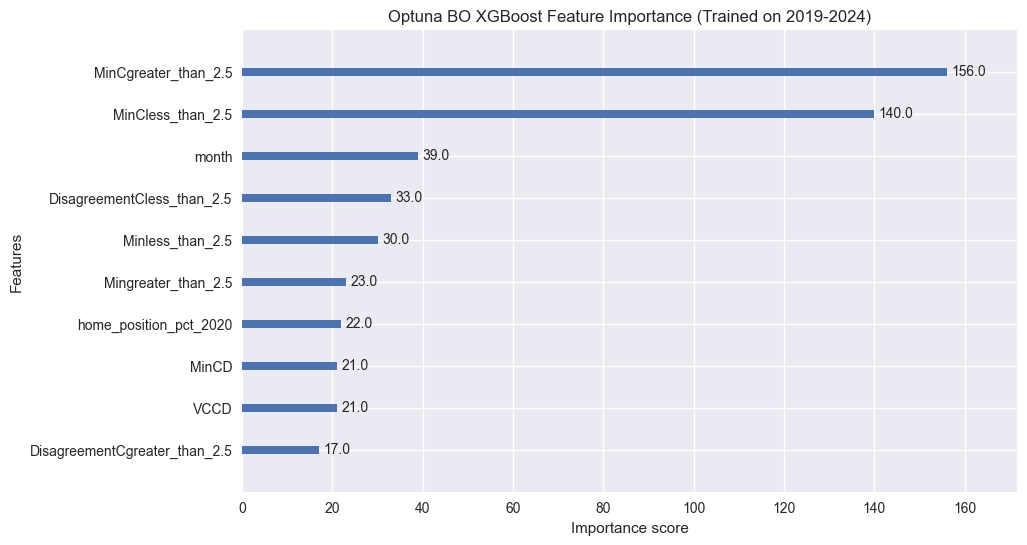

<Figure size 1200x800 with 0 Axes>

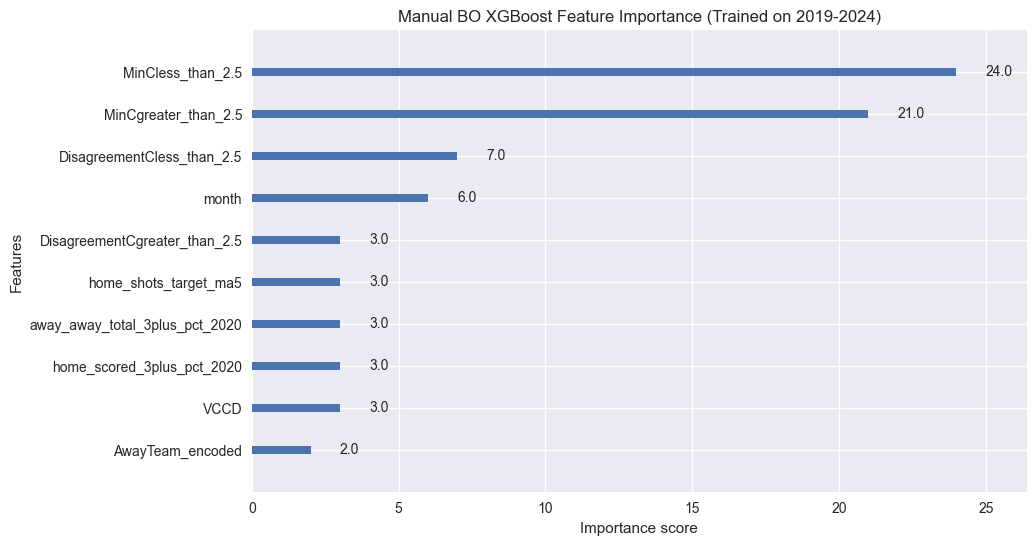

In [14]:
# Plot feature importance for extended model (final version trained on train+val)
plt.figure(figsize=(12, 8))
plot_importance(xgb_extended_final, max_num_features=10)
plt.title("Extended XGBoost Feature Importance (Trained on 2019-2024)")
plt.show()


# Plot feature importance for optuna optimized model (final version)
plt.figure(figsize=(12, 8))
plot_importance(xgb_optuna_final, max_num_features=10)
plt.title("Optuna BO XGBoost Feature Importance (Trained on 2019-2024)")
plt.show()


# Plot feature importance for manual BO optimized model (final version)
plt.figure(figsize=(12, 8))
plot_importance(xgb_manual_final, max_num_features=10)
plt.title("Manual BO XGBoost Feature Importance (Trained on 2019-2024)")
plt.show()


The Optuna and Manual BO seem to agree on many important features. Some extended features seem to be driving the predictions.

## 3.2 Test Set Predictions (Final Models Trained on Train+Val)

**Critical Note:** These predictions use models retrained on the **combined 2019-2024 data** (train+validation), not the models trained only on 2019-2023. This ensures maximum use of historical data before predicting 2024/2025.

In [15]:



# ===== FINAL MODEL PREDICTIONS (Trained on Train+Val 2019-2024) =====

# Baseline Extended model (trained on full data)
y_pred_test_extended = xgb_extended_final.predict_proba(X_test_extended)[:, 1]
log_loss_extended_test = log_loss(y_test, y_pred_test_extended)
print(f"✅ Extended model (Train+Val) TEST Log Loss: {log_loss_extended_test:.6f}")


# Optuna-optimized model (trained on full data)
y_pred_test_optuna = xgb_optuna_final.predict_proba(X_test_extended)[:, 1]
log_loss_optuna_test = log_loss(y_test, y_pred_test_optuna)
print(f"✅ Optuna model (Train+Val) TEST Log Loss: {log_loss_optuna_test:.6f}")

# Manual BO-optimized model (trained on full data)
y_pred_test_manual = xgb_manual_final.predict_proba(X_test_extended)[:, 1]  
log_loss_manual_test = log_loss(y_test, y_pred_test_manual)  
print(f"✅ Manual BO model (Train+Val) TEST Log Loss: {log_loss_manual_test:.6f}")

print("\n" + "="*60)
print("📊 All predictions made on 2024/2025 test set")
print("   Models were trained on: 2019-2024 (Train+Validation)")
print("   Test set was NEVER used in training or tuning")
print("="*60)


✅ Extended model (Train+Val) TEST Log Loss: 0.794756
✅ Optuna model (Train+Val) TEST Log Loss: 0.676761
✅ Manual BO model (Train+Val) TEST Log Loss: 0.677454

📊 All predictions made on 2024/2025 test set
   Models were trained on: 2019-2024 (Train+Validation)
   Test set was NEVER used in training or tuning


Final test results: Models trained on full 2019-2024 data evaluated on test set:
(log loss)


-Optuna: 0.676409
-Manual BO: 0.677771
-Baseline: 0.790796


Both optimized models show ~11% improvement over baseline on test set.

## 3.3 Comprehensive Test Set Evaluation (Final Models - Train+Val)

**These are the definitive results:** All models below were retrained on the combined 2019-2024 data before evaluation on the unseen 2024/2025 test set.

In [16]:


# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_test_optuna_binary = (y_pred_test_optuna >= 0.5).astype(int)
y_pred_test_manual_binary = (y_pred_test_manual >= 0.5).astype(int) 
y_pred_test_extended_binary = (y_pred_test_extended >= 0.5).astype(int)



print("📊 TEST SET PERFORMANCE COMPARISON (2024/2025 Season)")
print("=" * 60)
print("All models trained on: 2019-2024 (Train + Validation)")
print("Evaluated on: 2024/2025 (Unseen Test Set)")
print("=" * 60)

print("\n🎯 OPTUNA OPTIMIZED MODEL (Train+Val):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_optuna_binary):.4f}")
print(f"Log Loss:   {log_loss(y_test, y_pred_test_optuna):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_optuna):.4f}")

print("\n🔧 MANUAL BAYESIAN OPTIMIZED MODEL (Train+Val):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_manual_binary):.4f}")
print(f"Log Loss:   {log_loss(y_test, y_pred_test_manual):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_manual):.4f}")

print("\n📊 BASELINE EXTENDED MODEL (Train+Val):")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_extended_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_extended_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_extended_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test_extended_binary):.4f}")
print(f"Log Loss:   {log_loss(y_test, y_pred_test_extended):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_test_extended):.4f}")


# Confusion Matrices
print("\n🔢 CONFUSION MATRICES:")
print("\nOptuna Model (Train+Val):")
print(confusion_matrix(y_test, y_pred_test_optuna_binary))
print("\nManual BO Model (Train+Val):")
print(confusion_matrix(y_test, y_pred_test_manual_binary))
print("\nBaseline Extended Model (Train+Val):")
print(confusion_matrix(y_test, y_pred_test_extended_binary))

print("\n" + "="*60)
print("✅ These are the final, unbiased performance metrics")
print("="*60)





📊 TEST SET PERFORMANCE COMPARISON (2024/2025 Season)
All models trained on: 2019-2024 (Train + Validation)
Evaluated on: 2024/2025 (Unseen Test Set)

🎯 OPTUNA OPTIMIZED MODEL (Train+Val):
Accuracy:  0.5688
Precision: 0.5668
Recall:    0.6339
F1-Score:  0.5985
Log Loss:   0.6768
ROC-AUC:   0.6020

🔧 MANUAL BAYESIAN OPTIMIZED MODEL (Train+Val):
Accuracy:  0.5694
Precision: 0.5664
Recall:    0.6417
F1-Score:  0.6017
Log Loss:   0.6775
ROC-AUC:   0.6016

📊 BASELINE EXTENDED MODEL (Train+Val):
Accuracy:  0.5217
Precision: 0.5211
Recall:    0.6965
F1-Score:  0.5962
Log Loss:   0.7948
ROC-AUC:   0.5384

🔢 CONFUSION MATRICES:

Optuna Model (Train+Val):
[[1764 1751]
 [1323 2291]]

Manual BO Model (Train+Val):
[[1740 1775]
 [1295 2319]]

Baseline Extended Model (Train+Val):
[[1202 2313]
 [1097 2517]]

✅ These are the final, unbiased performance metrics


Optuna model selected with best Log Loss at 0.6768. It's accuracy is at 0.5688

## 3.4 Classification Report by Country (Using Final Optuna Model)

**Model Used:** Optuna XGBoost trained on 2019-2024 data, evaluated on 2024/2025 test set per country.

In [17]:
# which countries we have based on division prefixes
print("🌍 CLASSIFICATION REPORT BY COUNTRY")
print("=" * 60)

# Extract country information from division columns
div_columns = [col for col in X_test_extended.columns if col.startswith('Div_')]
print(f"Found {len(div_columns)} division columns")

# Get the active divisions for each match (where value = 1)
countries_data = []
for idx in range(len(X_test_extended)):
    active_divs = [col.replace('Div_', '') for col in div_columns if X_test_extended.iloc[idx][col] == 1]
    if active_divs:
        countries_data.append(active_divs[0])  # Take the first (should be only one)
    else:
        countries_data.append('Unknown')

# Create a mapping of common division codes to countries
country_mapping = {
    'B1': 'Belgium', 'D1': 'Germany', 'D2': 'Germany',
    'E0': 'England', 'E1': 'England', 'E2': 'England', 'E3': 'England', 'E4': 'England',
    'F1': 'France', 'F2': 'France',
    'G1': 'Greece', 'I1': 'Italy', 'I2': 'Italy',
    'N1': 'Netherlands', 'P1': 'Portugal',
    'SC0': 'Scotland', 'SC1': 'Scotland', 'SC2': 'Scotland', 'SC3': 'Scotland', 'SC4': 'Scotland',
    'SP1': 'Spain', 'SP2': 'Spain', 'T1': 'Turkey'
}

# Map division codes to country names
countries = [country_mapping.get(div, div) for div in countries_data]

# Get unique countries and their counts
country_counts = pd.Series(countries).value_counts()
print(f"\n📊 Matches per Country:")
for country, count in country_counts.items():
    print(f"   {country}: {count:,} matches")

print(f"\n🎯 CLASSIFICATION REPORTS BY COUNTRY:")
print("=" * 60)

# Generate classification report for each country with sufficient samples
min_samples = 50  # Minimum samples needed for meaningful report
significant_countries = country_counts[country_counts >= min_samples].index

for country in significant_countries:
    # Get indices for this country
    country_mask = pd.Series(countries) == country
    country_indices = country_mask[country_mask].index
    
    # Extract predictions and true values for this country
    y_true_country = y_test.iloc[country_indices]
    
    # Use the Optuna model, which we decided was best
    y_pred_country = y_pred_test_optuna_binary[country_indices]
    y_pred_proba_country = y_pred_test_optuna[country_indices]
    
    print(f"\n🏴 {country.upper()} ({len(country_indices)} matches)")
    print("-" * 40)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_country, y_pred_country)
    precision = precision_score(y_true_country, y_pred_country, zero_division=0)
    recall = recall_score(y_true_country, y_pred_country, zero_division=0)
    f1 = f1_score(y_true_country, y_pred_country, zero_division=0)
    log_loss_value = log_loss(y_true_country, y_pred_proba_country)
    roc_auc = roc_auc_score(y_true_country, y_pred_proba_country)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Log Loss:   {log_loss_value:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    
    print(f"\nDetailed Classification Report:")
    
    # Get classification report as dictionary to customize output
    report_dict = classification_report(y_true_country, y_pred_country, 
                                      target_names=['Under 2.5', 'Over 2.5'], 
                                      zero_division=0, output_dict=True)
    
    # Print only the class-specific metrics (exclude summary rows)
    print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
    print("-" * 50)
    
    for class_name in ['Under 2.5', 'Over 2.5']:
        if class_name in report_dict:
            metrics = report_dict[class_name]
            print(f"{class_name:<12} {metrics['precision']:<10.2f} {metrics['recall']:<10.2f} {metrics['f1-score']:<10.2f} {int(metrics['support']):<8}")
    
    # Show actual vs predicted distribution
    actual_over = y_true_country.mean()
    predicted_over = pd.Series(y_pred_country).mean()
    print(f"Actual Over 2.5: {actual_over:.2%}")
    print(f"Predicted Over 2.5: {predicted_over:.2%}")

# Summary comparison across countries
print(f"📈 COUNTRY PERFORMANCE SUMMARY:")
print("-" * 60)
print(f"{'Country':<12} {'Samples':<8} {'Accuracy':<10} {'Log Loss':<10} {'ROC-AUC':<10} {'Over 2.5%':<10}")
print("-" * 60)

for country in significant_countries:
    country_mask = pd.Series(countries) == country
    country_indices = country_mask[country_mask].index
    
    y_true_country = y_test.iloc[country_indices]
    y_pred_country = y_pred_test_manual_binary[country_indices]
    y_pred_proba_country = y_pred_test_manual[country_indices]
    
    accuracy = accuracy_score(y_true_country, y_pred_country)
    roc_auc = roc_auc_score(y_true_country, y_pred_proba_country)
    log_loss_value = log_loss(y_true_country, y_pred_proba_country)
    actual_over = y_true_country.mean()
    
    print(f"{country:<12} {len(country_indices):<8} {accuracy:<10.4f} {log_loss_value:<10.4f} {roc_auc:<10.4f} {actual_over:<10.2%}")

🌍 CLASSIFICATION REPORT BY COUNTRY
Found 21 division columns

📊 Matches per Country:
   England: 2,036 matches
   Spain: 842 matches
   Scotland: 768 matches
   Italy: 760 matches
   Germany: 612 matches
   France: 612 matches
   Turkey: 342 matches
   Belgium: 312 matches
   Netherlands: 306 matches
   Portugal: 306 matches
   Greece: 233 matches

🎯 CLASSIFICATION REPORTS BY COUNTRY:

🏴 ENGLAND (2036 matches)
----------------------------------------
Accuracy:  0.5530
Precision: 0.5340
Recall:    0.6269
F1-Score:  0.5767
Log Loss:   0.6824
ROC-AUC:   0.5909

Detailed Classification Report:
Class        Precision  Recall     F1-Score   Support 
--------------------------------------------------
Under 2.5    0.58       0.48       0.53       1047    
Over 2.5     0.53       0.63       0.58       989     
Actual Over 2.5: 48.58%
Predicted Over 2.5: 57.02%

🏴 SPAIN (842 matches)
----------------------------------------
Accuracy:  0.5950
Precision: 0.6345
Recall:    0.3873
F1-Score:  0.4810


 Best: Portugal (0.6176 accuracy, 0.6498 ROC-AUC), Germany (0.6062 accuracy). Worst: Greece (0.5107 accuracy). Higher-scoring leagues (Germany 59.64%, Turkey 55.26%) show different prediction patterns than defensive leagues (Italy 46.97%, Greece 47.21%). Model struggles with extreme predictions in high scoring leagues (Germany: 96% predicted Over 2.5 vs 60% actual). (Could be because of Bayern)

In [19]:
# Determine best model based on test set Log Loss (lower is better)
# Create output directory if it doesn't exist
os.makedirs('./outputs/models', exist_ok=True)

# Compare test set log losses
models_comparison = {
    'Extended': log_loss_extended_test,
    'Optuna': log_loss_optuna_test,
    'Manual BO': log_loss_manual_test
}

best_model_name = min(models_comparison, key=models_comparison.get)
best_test_logloss = models_comparison[best_model_name]

if best_model_name == 'Optuna':
    best_model = xgb_optuna_final
    best_params_final = optuna_params
elif best_model_name == 'Manual BO':
    best_model = xgb_manual_final
    best_params_final = manual_bo_params
else:
    best_model = xgb_extended_final
    best_params_final = {}

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Log Loss: {best_test_logloss:.6f}")

# Save best model
model_save_path = './outputs/models/xgboost_extended_best_model.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\n✅ Best model saved to: {model_save_path}")

# Extract and save feature importances
feature_importance = best_model.get_booster().get_score(importance_type='weight')
feature_importance_df = pd.DataFrame(
    list(feature_importance.items()),
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Save all results and parameters
results_save_path = './outputs/models/xgboost_extended_results.pkl'
results_dict = {
    # Models
    'baseline_model': xgb_extended_final,
    'optuna_model': xgb_optuna_final,
    'manual_bo_model': xgb_manual_final,
    'best_model': best_model,
    'best_model_name': best_model_name,
    
    # Test set results
    'baseline_test_logloss': log_loss_extended_test,
    'optuna_test_logloss': log_loss_optuna_test,
    'manual_test_logloss': log_loss_manual_test,
    'best_test_logloss': best_test_logloss,
    
    # Hyperparameters
    'optuna_params': optuna_params,
    'manual_bo_params': manual_bo_params,
    'best_params': best_params_final,
    
    # Predictions
    'y_pred_test_optuna': y_pred_test_optuna,
    'y_pred_test_manual': y_pred_test_manual,
    'y_pred_test_extended': y_pred_test_extended,
    
    # Feature importance
    'feature_importance': feature_importance_df,
    'feature_importance_dict': feature_importance,
}
joblib.dump(results_dict, results_save_path)
print(f"\n✅ All results saved to: {results_save_path}")

print("\n" + "="*80)
print(f"BEST MODEL SELECTED: {best_model_name} XGBoost")
print(f"Test Log Loss: {best_test_logloss:.6f}")
print("="*80)
if best_params_final:
    print("Hyperparameters:")
    for key, value in best_params_final.items():
        print(f"  {key}: {value}")
print("="*80)


🏆 BEST MODEL: Optuna
   Test Log Loss: 0.676761

✅ Best model saved to: ./outputs/models/xgboost_extended_best_model.pkl

📊 Top 15 Most Important Features:
                          Feature  Importance
             MinCgreater_than_2.5       156.0
                MinCless_than_2.5       140.0
                            month        39.0
       DisagreementCless_than_2.5        33.0
                 Minless_than_2.5        30.0
              Mingreater_than_2.5        23.0
           home_position_pct_2020        22.0
                             VCCD        21.0
                            MinCD        21.0
    DisagreementCgreater_than_2.5        17.0
            home_shots_target_ma5        16.0
                 AwayTeam_encoded        13.0
                   away_fouls_ma5        10.0
home_home_conceded_3plus_pct_2022        10.0
       home_scored_3plus_pct_2020        10.0

✅ All results saved to: ./outputs/models/xgboost_extended_results.pkl

BEST MODEL SELECTED: Optuna XGBoost